# Segmentation of mammo tiles

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from fastai.core import *
from fastai import *
from fastai.vision import *
import PIL

from pathlib import *
import pandas as pd
import numpy as np
import colorcet as cc

#from gray_image import *

cmap_grey = cc.cm.linear_grey_0_100_c0

In [3]:
path  = Path('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles')
#print(list(path.iterdir()))
dxrays = "xrays"
dmasks = "obs_masks"
dtrain = "train"
dvalid = "test"

In [4]:
from enum import Enum
class ObsType(Enum):
    EMPTY=0           ,"empty"                   # outside the breast
    NORMAL=1          ,"normal"                  # tissue with no segments
    BENIGN_CALC=2     ,"benign_calcification"    # tissue with benign calcification
    MALIGNANT_CALC=3  ,"malignant calcification"  # tissue with malignant calcification
    BENIGN_MASS=4     ,"benign_mass"              # tissue with a benign node
    MALIGNANT_MASS=5  ,"malignant mass"           # tissue with a malignant node
def enum2int(e): return e.value[0]

def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
     
def getColorBoundsNorm(cmap, codes ):
    cmap     = mpl.cm.get_cmap(cmap) if type(cmap)==str else cmap
    cmaplist = [cmap(i) for i in range(len(codes))]
    cmap     = LinearSegmentedColormap.from_list('cmap for codes', cmaplist, len(codes))
    bounds   = np.arange(len(codes)+1)
    norm     = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, bounds, norm

def plotImageMaskMosaic( ims, masks, codes, cmap="tab20", figsize=(9,12) ):
    nb    = len(ims)
    ncols = int(np.sqrt(nb))
    nrows = int(math.ceil(nb/ncols))

    fig  = plt.figure(figsize=figsize)
    
    cmap, bounds, norm = getColorBoundsNorm( cmap, codes )

    gs = gridspec.GridSpec(nrows, ncols, height_ratios=np.zeros(nrows)+ 2, wspace=0.0, hspace=0.0)
    
    for i in range(nb):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=gs[i], wspace=0.0, hspace=0.0)
        
        ax = plt.subplot(inner[0])
        ax.axis('off')
        ax.imshow(ims[i])

        ax = plt.subplot(inner[1])
        ax.axis('off')
        ax.imshow(masks[i],norm=norm, cmap=cmap)

def showColorEncoding(codes, cmap="ctab20") :
    fig, ax = plt.subplots(figsize=(1, 12))
    fig.subplots_adjust(bottom=0.5)

    cmap, bounds, norm = getColorBoundsNorm( cmap, codes )
    cb3 = mpl.colorbar.ColorbarBase(ax,cmap=cmap,norm=norm, boundaries=[-10] + bounds + [10],
                                    ticks=bounds, spacing='uniform', orientation='vertical')
    cb3.set_label('color encoding of class codes')
    cb3.ax.yaxis.set_label_coords(1.25, .5)
    cb3.set_ticklabels(codes)
    cb3.set_ticks(0.5+bounds)
    cb3.ax.yaxis.set_ticks_position('left')


In [ ]:
cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
#print(f"cases.columns:{cases.columns}")
cases.drop("Unnamed: 0",axis=1,inplace=True)
#display(cases.tail(2))

#print("Stat of dataset before selection")
#gp = cases.groupby( ["purpose", "observation", "simple_pathology"])["fnImage"].count()
#print( gp )

codes = [obs.name.lower() for obs in ObsType]
#print(f"codes:{codes}")

complexity={
            "malignant_calc":"malignant_calc > 0.01*tile_size and benign_calc==0    and empty==0",
            "benign_calc":   "benign_calc    > 0.02*tile_size and malignant_calc==0 and empty==0"
#            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
#            "malignant_calc":"malignant_calc > 0.1*tile_size and malignant_calc > 0.5*obsAreas and benign_calc==0 and empty==0",
#            "pAir":"pAir>0.2 and pAir<1.0", 
#            "benign_calc":"benign_calc/tile_size>0.1 and benign_calc > 0.5*obsAreas and malignant_calc==0 and empty==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=1000

test   = selectCases( cases, "test",  complexity=complexity, nb=nb//2 )
train  = selectCases( cases, "train", complexity=complexity, nb=nb )
dfData = test.append(train)
print("Selected dataset")
display(dfData.head())
gp = dfData.groupby( ["purpose", "observation", "classes"])["fnImage"].count()
print( gp )


Selected dataset


,case_id,height,width,simple_pathology,patient_id,purpose,density,left_right,projection,obs id,...,malignant_calc,benign_mass,malignant_mass,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask,classes
131,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,35066,0,0,0.55,0.46,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,malignant_calc
132,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,48709,0,0,0.59,0.62,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,malignant_calc
133,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,48460,0,0,0.64,0.40,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,malignant_calc
146,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.0,RIGHT,MLO,1,...,23367,0,0,0.85,0.50,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,malignant_calc
147,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.0,RIGHT,MLO,1,...,42245,0,0,0.75,0.49,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,malignant_calc


purpose  observation    classes       
test     calcification  benign_calc       169
                        malignant_calc    167
train    calcification  benign_calc       916
                        malignant_calc    667
Name: fnImage, dtype: int64


In [ ]:
#dfData = cases[np.isin(cases.case_id, selection )]

#calculate the weights of the classes in the loss function
gp = dfData.groupby(["purpose"])[codes].mean().astype(np.int)
print("average number of pixels pr class")
print(gp)

s = gp.sum(axis=1)
gp.iloc[0] /= s.iloc[0]
gp.iloc[1] /= s.iloc[1]
print("\nfrequency of pixel codes")
pd.options.display.float_format = '${:,.3f}'.format
print(gp)

code_weights = 1. / (gp+1e-6)
code_weights[gp==0] = 0
#print("code_weights\n", code_weights)

s = code_weights.sum(axis=1)
code_weights.iloc[0] /= s.iloc[0]
code_weights.iloc[1] /= s.iloc[1]
#print(code_weights)
code_weights = code_weights.iloc[0].values
[print(f"code:{c} weigth:{w:.3f}") for c,w in zip(codes,code_weights)]

gc.collect()

average number of pixels pr class
         empty  normal  benign_calc  malignant_calc  benign_mass  \
purpose                                                            
test         0  888387        56617          103570            0   
train        0  893745        60376           94454            0   

         malignant_mass  
purpose                  
test                  0  
train                 0  

frequency of pixel codes
         empty  normal  benign_calc  malignant_calc  benign_mass  \
purpose                                                            
test    $0.000  $0.847       $0.054          $0.099       $0.000   
train   $0.000  $0.852       $0.058          $0.090       $0.000   

         malignant_mass  
purpose                  
test             $0.000  
train            $0.000  
code:empty weigth:0.000
code:normal weigth:0.040
code:benign_calc weigth:0.621
code:malignant_calc weigth:0.339
code:benign_mass weigth:0.000
code:malignant_mass weigth:0.000


9

In [ ]:
def noise_zm( scale, w ):
    s = 1+scale*(np.random.rand(len(w))-.5)*2
    w *= s
    return s/s.sum()
def noise_p( scale, size ):
    return scale*np.random.rand(size)
def noise_weigths( scale, w ):
    #add uniform noise at scale to non zero w
    wn = w + scale*np.random.rand(len(w))*(w>0)
    return wn/wn.sum()

def torch_weigths_add_noise( scale, w ):
    #add uniform noise at scale to non zero w
    wn = w + scale*torch.rand(len(w))
    wn[w.le(0)] = 0
    return wn/wn.sum()

def torch_weigths_mult_noise( scale, w ):
    #add uniform noise at scale to non zero w
    s  = 1.0 + scale*2.*( torch.rand(len(w))-0.5)  
    w  = w*s
    return w/w.sum()

w = np.zeros(5)+1
s = noise_zm(.2,w)

print(f"s:{s}")
print(f"mean,sd: {s.mean()}  {s.std()}  {s.min()}  {s.max()}")

s:[0.185173 0.207602 0.217735 0.15863  0.230861]
mean,sd: 0.20000000000000004  0.025518825045347495  0.15862956424791183  0.23086094826363715


In [ ]:
scale = 0.5
w  = noise_weigths( scale, code_weights )
ix = w>0.

wt = torch.from_numpy(code_weights.astype(np.float32))
w2 = torch_weigths_mult_noise( scale, wt  )
ixt = w2>0.
print(w2)

#print(.2 * (np.random.ranf()-.5) + 1)
print(f"code_weights:{code_weights}" )
print(f"           w:{w2}" )
print(f"          w2:{w2/(1e-6+wt)}" )
print(f"code_weights   -mean,sd: {code_weights.mean()}  {code_weights.std()}  {code_weights.min()}  {code_weights.max()}")
print(f"code_weights+s -mean,sd: {w[ix].mean()}  {w[ix].std()}  {w[ix].min()}  {w[ix].max()}")
print(f"code_weights+s2-mean,sd: {w2[ixt].mean()}  {w2[ixt].std()}  {w2[ixt].min()}  {w2[ixt].max()}")


tensor([0.0000, 0.0264, 0.5292, 0.4444, 0.0000, 0.0000])
code_weights:[0.       0.039575 0.620967 0.339457 0.       0.      ]
           w:tensor([0.0000, 0.0264, 0.5292, 0.4444, 0.0000, 0.0000])
          w2:tensor([0.0000, 0.6670, 0.8523, 1.3090, 0.0000, 0.0000])
code_weights   -mean,sd: 0.16666666666666666  0.23654863361804015  0.0  0.6209674991278945
code_weights+s -mean,sd: 0.3333333333333333  0.10818619048530675  0.25096006102181206  0.4861773056748708
code_weights+s2-mean,sd: 0.3333333432674408  0.26917967200279236  0.026398219168186188  0.5292371511459351


In [ ]:
def getSegmentationTransforms():
    max_zoom     = 1.1
    max_rotate   = 0.1
    brightnes_range = (0.8, 1.0)
    contrast_range  = (0.85, 1.05)
    rotate_range    = (-10, 10) # degrees
    warp_range     = (-0.1, 0.1)
    tfmTrain,tfmValid =[],[]
    tfmTrain.append(crop_pad())
    #tfmTrain.append( rand_crop() )
    tfmTrain.append( dihedral_affine() )
    
    tfmTrain.append( rotate(degrees=rotate_range, p=.5) )
    """
    #tfmTrain.append( flip_affine(p=0.5) )
    
    #tfmTrain.append( skew( np.arange, p=0.75) )
    tfmTrain.append( symmetric_warp(magnitude=warp_range, p=0.5) )
    #tfmTrain.append( perspective_warp(magnitude=warp_range, p=0.25) )
    
    #tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )

    tfmTrain.append( jitter(magnitude=0.01) )
    """
    
    if brightnes_range is not None: tfmTrain.append( brightness(change=brightnes_range, p=0.25) )
    if contrast_range is not None:  tfmTrain.append( contrast(scale=contrast_range,     p=0.25) )
        
    tfmValid.append(crop_pad())
    #tfmValid.append( flip_affine(p=0.5) )
    return (tfmTrain, tfmValid)

In [ ]:
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False

train  = join_paths(dfData.fnImage[ixTrain].values, path/dtrain/dxrays)
valid  = join_paths(dfData.fnImage[ixValid].values, path/dvalid/dxrays)

get_y_fn   = lambda x: x.parents[1]/dmasks/x.name 
valid_func = lambda x: x.parts[-3] == dvalid

def open_image_16bit2rgb( fn ): 
    a = np.asarray(PIL.Image.open( fn ))
    a = np.expand_dims(a,axis=2)
    a = np.repeat(a, 3, axis=2)
    return Image( pil2tensor(a, np.float32 ).div(65535) )

vision.data.open_image = open_image_16bit2rgb

src = (SegmentationItemList( list(train+valid), create_func=open_image_16bit2rgb, path="")
                           .split_by_valid_func(valid_func)
                           .label_from_func(get_y_fn, classes=codes)           
      )

In [ ]:
bs,size=16,224
data = ( src.transform(getSegmentationTransforms(), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats) )
#data.show_batch(2, figsize=(10,7))

In [ ]:
#import fastai.core
#from fastai.layers import *
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

def accuracy_(input, target):
    #The input.argmax(dim=1) selects the winner class pr pixel, thereby reducing 
    #the input shape from (bs, classes, width, height) => (bs, width, height)
    #We, therefore, have to reshape the target tensor from (bs, 1, width, height) to (bs, width, height)
    sz     = target.size()
    target = target.reshape( (sz[0],sz[2],sz[3]) )
    return (input.argmax(dim=1).flatten()==target.flatten()).float().mean()

def torch_weigths_add_noise( scale, w ):
    #add uniform noise at scale to non zero w
    wn = w + scale*torch.rand(len(w)).cuda()
    wn[w.le(0)] = 0
    return wn/wn.sum()

def torch_weigths_mult_noise( scale, w ):
    #add uniform noise at scale to non zero w
    s  = 1.0 + scale*2.*( torch.rand(len(w)).cuda()-0.5)  
    w  = w*s
    return w/w.sum()
"""
class WeighedCrossEntropy(CrossEntropyFlat):
    def __init__( self, weights ):
        super().__init__(weight=torch.from_numpy( np.asarray(weights,np.float32) ).cuda() )
        self.register_buffer("weight_mask",torch.from_numpy( (weights>0.0).astype(np.float32) ).cuda())
                             
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        scale  = .5
        w      = torch_weigths_mult_noise(scale, self.weight)
        n,c,*_ = input.shape
        return F.cross_entropy(input.view(n, c, -1), target.view(n, -1), weight=w,
                               ignore_index=self.ignore_index, reduction=self.reduction)
"""


class DiceLoss(nn.Module):
    dicemsg=""
    @staticmethod
    def dice_loss_1ch(input, target):
        smooth = 1.
        input = torch.sigmoid(input)
        iflat = input.view(-1)
        tflat = target.view(-1)
        #DiceLoss.dicemsg = (f"shape of input:{input.shape}, target:{target.shape} \
        #                     input.type():{input.type()} iflat.type():{iflat.type()}  tflat.type():{tflat.type()}")
        intersection = (iflat * tflat).sum()
        return 1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
        
        #prediction = self.sigmoid(output)
        #return 1 - 2 * torch.sum(prediction * target) / (torch.sum(prediction) + torch.sum(target) + 1e-7)
        
    @staticmethod
    def dice_loss_nch(input, target):
        dlc = 0
        bs, n_classes = input.shape[:2] 
        target = target.squeeze().float()
        n_real_classes=0
        for i in range(n_classes):
            if code_weights[i] > 0:
                dlc += DiceLoss.dice_loss_1ch(input[:,i], target)
                n_real_classes+=1
        return dlc/n_real_classes/bs
    
    def __init__(self):
        super().__init__()
        #super(DiceLoss, self).__init__()
        self.smooth = 1.
                             
    def forward(self, input, target):
        #input = torch.sigmoid(input)
        #preds = input.argmax(dim=1)
        #preds = preds.view(preds.shape[0], -1, preds.shape[1], preds.shape[2] )
        #preds = preds.view_as(target)
        #DiceLoss.dicemsg = (f"shape of input:{input.shape} of target:{target.shape} preds:{preds.shape} preds\n{preds}")
        return DiceLoss.dice_loss_nch(input,target)

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(np.float32)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()    

In [ ]:
[print(f"code:{c} weigth:{w:.3f}") for c,w in zip(codes,code_weights)]
learn = Learner.create_unet(data, models.resnet34, loss_func= DiceLoss(), # FocalLoss(gamma=2.,alpha=.25), # WeighedCrossEntropy(code_weights),  
                            metrics=accuracy_)


code:empty weigth:0.000
code:normal weigth:0.040
code:benign_calc weigth:0.621
code:malignant_calc weigth:0.339
code:benign_mass weigth:0.000
code:malignant_mass weigth:0.000


In [ ]:
DiceLoss.dicemsg

''

In [ ]:
lr_find(learn)
n=gc.collect()
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


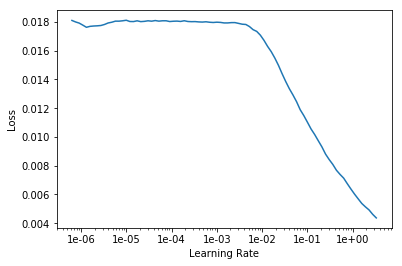

In [ ]:
learn.recorder.plot()

In [ ]:
lr=2e-3
learn.fit_one_cycle(6, slice(lr))
n=gc.collect()
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,accuracy_
1,0.009404,-0.004333,0.098531


In [ ]:
learn.save('resnet34-stage-1')
n=gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.load('resnet34-stage-1');

In [ ]:
learn.show_results(rows=bs)

In [ ]:
torch.cuda.empty_cache()
gc.collect()
bs,size=4,448
data = (src.transform(getSegmentationTransforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = Learner.create_unet(data, models.resnet34, loss_func= WeighedCrossEntropy(code_weights), 
                            metrics=accuracy_)
learn.loss_func= WeighedCrossEntropy(code_weights)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=2e-3
learn.fit_one_cycle(6, lr)

In [ ]:
learn.recorder.plot_losses(), plt.show(), learn.recorder.plot_metrics()

In [ ]:
learn.save('resnet34-stage-2');

In [ ]:
learn.show_results(rows=bs)

# GO BIG

In [ ]:
#bs,size=4,448
bs,size=4//2,2*448
data = (src.transform(getSegmentationTransforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = Learner.create_unet(data, models.resnet34, loss_func= WeighedCrossEntropy(code_weights), 
                            metrics=accuracy_)

In [ ]:
learn.load('resnet34-stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-7,lr/5)
learn.fit_one_cycle(6, lrs, moms=(0.97,0.92) )
n=gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.recorder.plot_losses(), plt.show(), learn.recorder.plot_metrics()

In [ ]:
learn.show_results(rows=bs)

In [ ]:
learn.save('resnet34-stage-big-good');

In [ ]:
def getResults(learn, n:int, ds_type=DatasetType.Valid):
    ds = learn.dl(ds_type).dataset
    xys, y_p, preds,  = [],[],None
    ip = 0
    for i in range(n):
        xys.append( ds[i] )
        if preds is None or preds.shape[0] <= ip:
            preds = learn.pred_batch(ds_type)
            ip    = 0
        y_p.append(preds[ip])
        ip += 1
        
    x,y,p=[],[],[]
    for i, xy in enumerate(xys):
        x_,y_ = xy
        x.append(x_)
        y.append(y_)
        p.append(y_.reconstruct_output(y_p[i],x_) )
    return x,y,p
    #print(f"{len(x)}, {len(y)}, {len(p)}")
    
xs,ys,y_ps = getResults(learn,n=20)


In [ ]:
xs[0].show(), ys[0].show(),  y_ps[0].show()

In [ ]:
n=9
ims,masks = [],[]
for i in range(n):
    x,y = data.train_ds[i]
    ims.append(   image2np(x.data) ) 
    masks.append( image2np(y.data) )
print("classes i mask:"), [print(f"mask {i}:{np.unique(m)}") for i,m in enumerate(masks)]

cmap=plt.cm.tab10
showColorEncoding(codes, cmap=cmap)     
plotImageMaskMosaic(ims, masks, codes, cmap=cmap, figsize=(10,14))

print(data.classes) len(data.classes),data.c